In [127]:
print("\n--- Bem vindo ao Projeto de Reconhecimento de Audio ---")
print("\nRealizando Imports de Libs necessarias...")

import librosa
import glob
import random
import re
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import scipy.signal as sg
# from scipy.fftpack import dct
# from scipy.fftpack import fft
# from scipy.fftpack import ifft
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix



--- Bem vindo ao Projeto de Reconhecimento de Audio ---

Realizando Imports de Libs necessarias...


In [149]:
# calculo do Chroma Energy Normalized Statistics (CENS) do sinal
def calc_chroma(segmento, sr):
    av = segmento.to_numpy(copy=True)
    return np.mean(librosa.feature.chroma_cens(y=av, sr=sr, n_chroma=24).T, axis=0)

# calculo do Mel Spectrogram do sinal
def calc_mel(segmento, sr):
    av = segmento.to_numpy(copy=True)
    return np.mean(librosa.feature.melspectrogram(av, sr=sr).T, axis=0)

# calculo do MFCC medio para cada audio de entrada
def calc_mfcc(segmento, sr):
    av = segmento.to_numpy(copy=True)
    return np.mean(librosa.feature.mfcc(y=av, sr=sr, n_mfcc=24).T, axis=0)

def lowPassFilter(signal):
    N  = 5   # Filter order
    Wn = 0.2 # Cutoff frequency
    B, A = sg.butter(N, Wn, output='ba')
    smooth_data = sg.filtfilt(B,A, signal)
    return smooth_data

In [3]:

# realiza a extracao de features do sinal
def feature_extraction(segmento, sr):
    features = []
    np.array(features)

    features = np.append(features, calc_mfcc(segmento, sr))
    features = np.append(features, calc_mel(segmento, sr))
    features = np.append(features, calc_chroma(segmento, sr))
    """
    features = np.append(features, calc_dct(segmento))
    features = np.append(features, calc_fft(segmento))
    """
    return features

# divisao dos audios de entrada para separacao de cada letra
def extract_intervals(signal, cut):
    data_interval = []
    interval = int(len(signal) // cut)
    for i in range(0, cut) :
        data_interval.append(pd.Series(signal[i*interval : (i+1)*interval]))
    return data_interval

# quebra o nome do arquivo em letras para categorizacao dos audios
def get_labels(path_file):
    path_file = re.sub("[ (1)]", "", path_file)
    return list(path_file[-8:-4])

# faz a aquisicao do caminho de todos os arquivos na pasta path
def get_files(path):
    files = glob.glob(path + "*.wav")
    return files

def get_x_y(path, reduce=False):
    files = get_files(path)
    Xt = []
    yt = []
    segmentos = []
    seed = random.randint(1, 1000)
    random.seed(seed)
    random.shuffle(files)
    # print(f"Semente gerada: {seed}\n")
    i = 0
    for f in files:
        data, sr = librosa.load(f, mono=True)
        segmentos += extract_intervals(data, 4)
        yt += get_labels(f)
        # print(i)
        if i > 30 and reduce:
            break    
        i += 1
        

    for segmento in segmentos:
        Xt.append(feature_extraction(segmento, sr))
    
    return Xt,yt

# lista os elementos (caracteres) unicos de um array
def unique_values(l):
    unique_list = []
    for x in l: 
        if x not in unique_list: 
            unique_list.append(x)
    return unique_list

In [4]:
# gera e imprime a matriz de confusao geral do modelo
def print_conf_mtx(yt, y_pred, labels, classifier):
    print(labels)
    print()
    cm = confusion_matrix(yt, y_pred, labels)
    print(cm)
    """
    print("\nMatrizes de Confusao Individuais")
    print(multilabel_confusion_matrix(yt, y_pred))
    """
    
    print("\nPlotando Confusion Matrix geral usando o matplotlib...")
    print("Feche o arquivo de saída para continuar a execução")

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the ' + classifier + ' classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.locator_params(nbins=len(labels))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [5]:
train_path = 'TREINAMENTO/'
validation_path= 'VALIDACAO/'
test_path = ''

In [14]:
reduce = True
files = get_files(train_path)
Xt = []
yt = []
segmentos = []
seed = 4
random.seed(seed)
random.shuffle(files)
# print(f"Semente gerada: {seed}\n")
i = 0
for f in files:
    data, sr = librosa.load(f, mono=True)
    segmentos += extract_intervals(data, 4)
    yt += get_labels(f)
    # print(i)
    if i > 30 and reduce:
        break    
    i += 1

In [19]:
labels = unique_values(yt)

In [22]:
labels

['h', '6', 'b', '7', 'n', 'c', 'x', 'a', 'm', 'd']

In [23]:
df_seg = pd.DataFrame(segmentos)

In [29]:
df_seg = df_seg.dropna(axis='columns')

In [32]:
df_seg['class'] = yt

C:\Users\renan\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [37]:
b = df_seg[df_seg['class'] == 'b']

In [40]:
m = df_seg[df_seg['class'] == 'm']

In [42]:
n = df_seg[df_seg['class'] == 'n']

In [151]:
d = df_seg[df_seg['class'] == 'd']

In [152]:
problem = pd.concat([m,n,b,d])

In [206]:
problem.reset_index(drop=True)

,0,1,2,3,4,5,6,7,8,9,...,43383,43384,43385,43386,43387,43388,43389,43390,43391,class
0,-4.254727e-04,5.002937e-05,-2.028223e-04,-3.952060e-04,-5.555779e-04,-5.398922e-04,-3.551907e-04,-7.048526e-04,-7.973507e-04,-6.134242e-04,...,-6.381314e-04,-2.819169e-04,-3.080497e-04,-2.481881e-04,-1.470843e-04,-4.277031e-04,-5.151418e-04,-7.799501e-05,-1.707797e-04,m
1,7.471550e-04,7.698749e-04,7.599248e-04,7.450916e-04,9.181282e-04,9.035604e-04,8.557300e-04,8.243818e-04,7.052530e-04,6.257596e-04,...,-1.112553e-06,-3.554457e-05,-4.889154e-06,-4.986290e-05,-7.034383e-05,-1.289229e-04,-1.396136e-04,-1.704333e-04,-1.772180e-04,m
2,6.432583e-04,1.044618e-03,9.931417e-04,1.078376e-03,1.180275e-03,1.056174e-03,9.127752e-04,9.821419e-04,9.476504e-04,1.029394e-03,...,-6.645052e-04,-4.895679e-04,-3.036205e-04,-3.481277e-04,-4.527492e-04,-3.274836e-04,-3.386394e-04,-4.355991e-04,-5.386436e-04,m
3,1.912124e-04,2.015952e-04,1.811411e-04,1.208233e-04,3.002750e-05,-1.455669e-06,-3.275615e-05,-9.344793e-05,-1.176401e-04,-1.692013e-04,...,-4.991598e-06,-3.507085e-05,-2.180298e-05,1.608605e-06,-1.024054e-06,-6.740082e-06,-8.690227e-07,8.950092e-07,-9.502438e-07,m
4,6.465586e-06,1.005217e-06,-8.828192e-07,7.781906e-07,-6.840844e-07,5.975750e-07,-5.175360e-07,4.435645e-07,-3.754625e-07,3.129820e-07,...,-2.593838e-07,2.312128e-07,-2.033189e-07,1.762451e-07,-1.505306e-07,1.266881e-07,-1.051823e-07,8.640814e-08,-7.067231e-08,m
5,-8.054463e-07,1.202527e-06,-2.011768e-06,1.313384e-05,3.672762e-06,1.758054e-05,2.646805e-05,3.846281e-05,5.280637e-05,4.021439e-05,...,-1.814301e-03,-1.097035e-03,-1.393401e-03,-1.628521e-03,-8.928204e-04,-7.458932e-04,-2.294478e-04,-3.077453e-04,3.202275e-04,m
6,-9.721246e-04,-1.147703e-03,-1.726534e-03,-9.071636e-04,-1.307346e-03,-1.785891e-03,-1.457659e-03,-1.409650e-03,-1.426950e-03,-1.977884e-03,...,-1.286190e-03,-2.211368e-03,-2.414280e-03,-1.466580e-03,-1.094828e-03,-1.310954e-03,-2.021431e-03,-1.208504e-03,-2.138302e-03,m
7,-1.239485e-04,-8.502370e-05,-1.398683e-04,-7.016881e-05,-1.513496e-04,-9.466533e-05,-1.089160e-04,-5.536612e-05,-8.640424e-05,-2.066285e-05,...,-8.821423e-06,1.082845e-05,-3.883172e-05,-3.946284e-05,-5.012481e-05,-8.948571e-05,-6.744746e-05,-1.006231e-04,-8.197072e-05,m
8,2.644694e-04,-1.555193e-04,-2.255589e-05,-1.124399e-04,-5.414367e-05,-4.152483e-05,-3.016484e-05,-8.112097e-05,-3.120834e-05,-5.555419e-06,...,7.590062e-05,1.150811e-04,2.514548e-04,-3.122054e-04,3.173777e-04,5.362803e-04,5.222980e-04,7.324398e-04,4.220119e-04,m
9,-6.989986e-04,-9.001745e-05,2.998988e-05,-1.515657e-04,-2.764112e-04,-6.450540e-04,-2.118771e-04,-5.623039e-04,-1.601121e-04,-2.680378e-04,...,-2.256627e-03,-2.403589e-03,-2.030704e-03,-2.689580e-03,-2.492108e-03,-1.898199e-03,-1.890878e-03,-2.086041e-03,-2.547618e-03,m


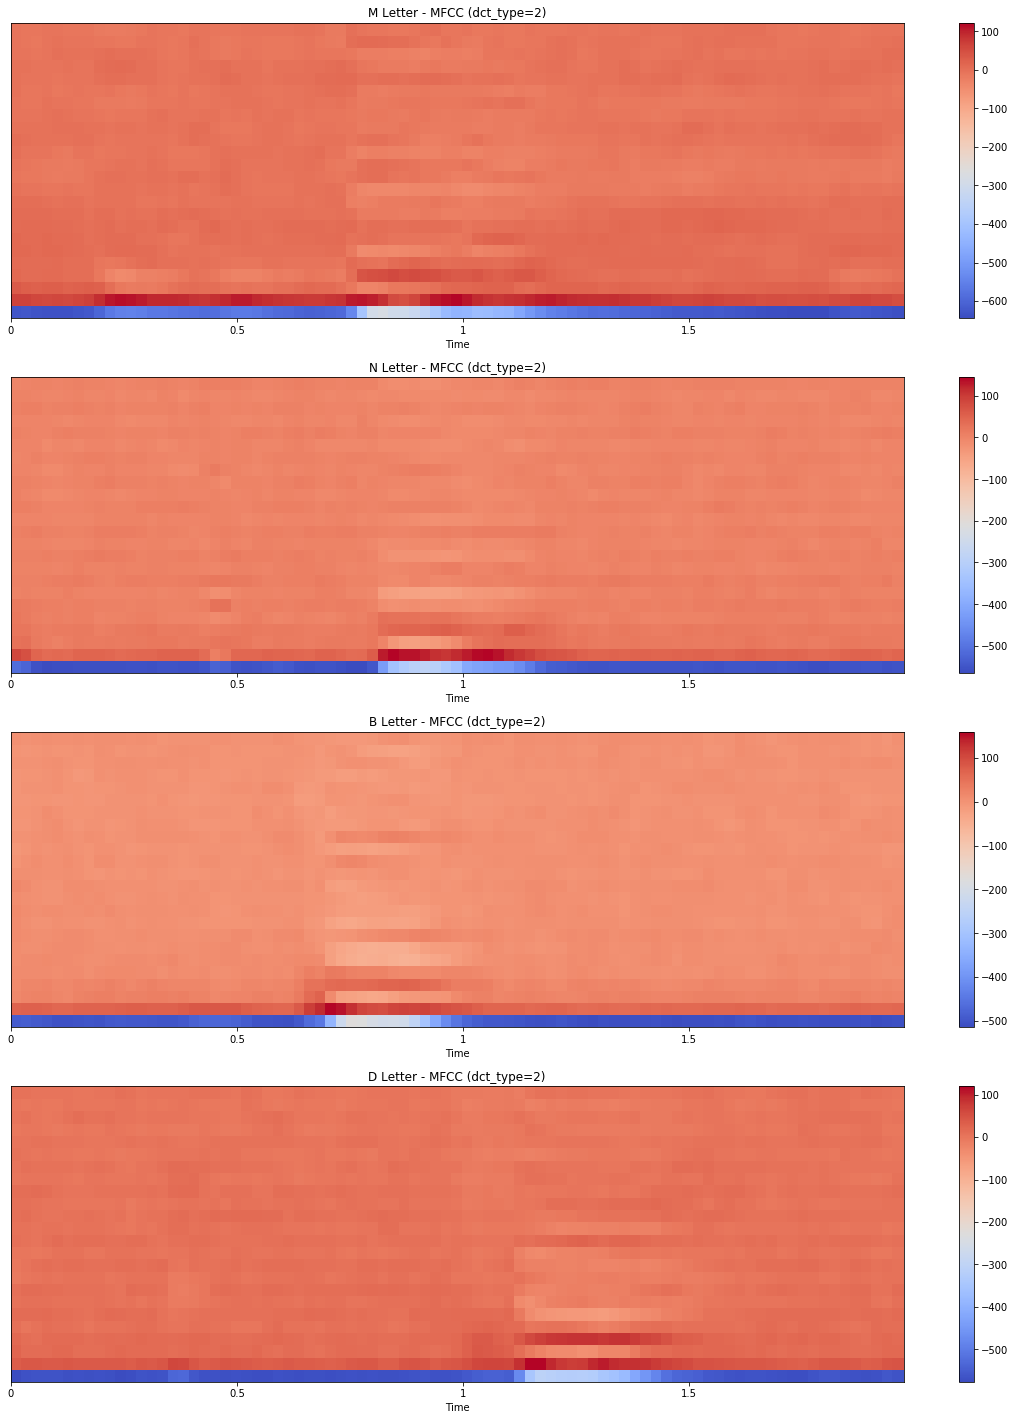

In [207]:
import librosa.display
m_slaney = librosa.feature.mfcc(y=problem.iloc[1,:43392].to_numpy(copy=True).astype(np.floating), sr=sr, n_mfcc=24, dct_type=2)
plt.figure(figsize=(20, 25))
plt.subplot(4, 1, 1)
librosa.display.specshow(m_slaney, x_axis='time')
plt.title('M Letter - MFCC (dct_type=2)')
plt.colorbar()


m_slaney = librosa.feature.mfcc(y=problem.iloc[11,:43392].to_numpy(copy=True).astype(np.floating), sr=sr, n_mfcc=24, dct_type=2)
plt.subplot(4, 1, 2)
librosa.display.specshow(m_slaney, x_axis='time')
plt.title('N Letter - MFCC (dct_type=2)')
plt.colorbar()


m_slaney = librosa.feature.mfcc(y=problem.iloc[30,:43392].to_numpy(copy=True).astype(np.floating), sr=sr, n_mfcc=24, dct_type=2)
plt.subplot(4, 1, 3)
librosa.display.specshow(m_slaney, x_axis='time')
plt.title('B Letter - MFCC (dct_type=2)')
plt.colorbar()


m_slaney = librosa.feature.mfcc(y=problem.iloc[44,:43392].to_numpy(copy=True).astype(np.floating), sr=sr, n_mfcc=24, dct_type=2)
plt.subplot(4, 1, 4)
librosa.display.specshow(m_slaney, x_axis='time')
plt.title('D Letter - MFCC (dct_type=2)')
plt.colorbar()

plt.savefig("mfcc_M_N_B_D.png")
plt.show()


In [ ]:
S = librosa.feature.melspectrogram(y=problem.iloc[1,:43392].to_numpy(copy=True).astype(np.floating), sr=sr, n_mels=128,fmax=8000)

plt.figure(figsize=(20, 25))
plt.subplot(4, 1, 1)
S_dB = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title('M Letter - Mel-frequency spectrogram')
plt.tight_layout()

S = librosa.feature.melspectrogram(y=problem.iloc[11,:43392].to_numpy(copy=True).astype(np.floating), sr=sr, n_mels=128,fmax=8000)

plt.subplot(4, 1, 2)
S_dB = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title('N Letter - Mel-frequency spectrogram')
plt.tight_layout()

S = librosa.feature.melspectrogram(y=problem.iloc[30,:43392].to_numpy(copy=True).astype(np.floating), sr=sr, n_mels=128,fmax=8000)

plt.subplot(4, 1, 3)
S_dB = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title('Letter B - Mel-frequency spectrogram')
plt.tight_layout()


S = librosa.feature.melspectrogram(y=problem.iloc[44,:43392].to_numpy(copy=True).astype(np.floating), sr=sr, n_mels=128,fmax=8000)

plt.subplot(4, 1, 4)
S_dB = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title('Letter D - Mel-frequency spectrogram')
plt.tight_layout()

plt.savefig('mel_M_N_B_D.png')
plt.show()


In [ ]:
plt.figure(figsize=(20, 25))
chr = librosa.feature.chroma_cqt(y=problem.iloc[1,:43392].to_numpy(copy=True).astype(np.floating), sr=sr, n_chroma=24)
plt.subplot(4, 1, 1)
librosa.display.specshow(chr, y_axis='chroma')
plt.title('Letter M - CHROMA')
plt.colorbar()

chr = librosa.feature.chroma_cqt(y=problem.iloc[11,:43392].to_numpy(copy=True).astype(np.floating), sr=sr, n_chroma=24)
plt.subplot(4, 1, 2)
librosa.display.specshow(chr, y_axis='chroma', x_axis='time')
plt.title('Letter N - CHROMA')
plt.colorbar()
plt.tight_layout()


chr = librosa.feature.chroma_cqt(y=problem.iloc[30,:43392].to_numpy(copy=True).astype(np.floating), sr=sr, n_chroma=24)
plt.subplot(4, 1, 3)
librosa.display.specshow(chr, y_axis='chroma', x_axis='time')
plt.title('Letter B - CHROMA')
plt.colorbar()
plt.tight_layout()


chr = librosa.feature.chroma_cqt(y=problem.iloc[44,:43392].to_numpy(copy=True).astype(np.floating), sr=sr, n_chroma=24)
plt.subplot(4, 1, 4)
librosa.display.specshow(chr, y_axis='chroma', x_axis='time')
plt.title('Letter D - CHROMA')
plt.colorbar()
plt.tight_layout()

plt.savefig('chr_M_N_B_D.png')
plt.show()